# Network Construction Proposal

After investigating servral research papers in the vision ML field, here I proposal the specific network design.
</br>

Following code blocks were implemented in **PyTorch**.
For more details, please click [here](https://www.pytorch.org).

## DCGAN: Generate Fake Image for Training

Considering that we don't have so much image resource for model training, the first sub-module will be the [DCGAN](http://arxiv.org/abs/1511.06434). This sub-module will fucous on generate a larger dataset from the original dataset. 

Following figure is the sample construction of this submodule.
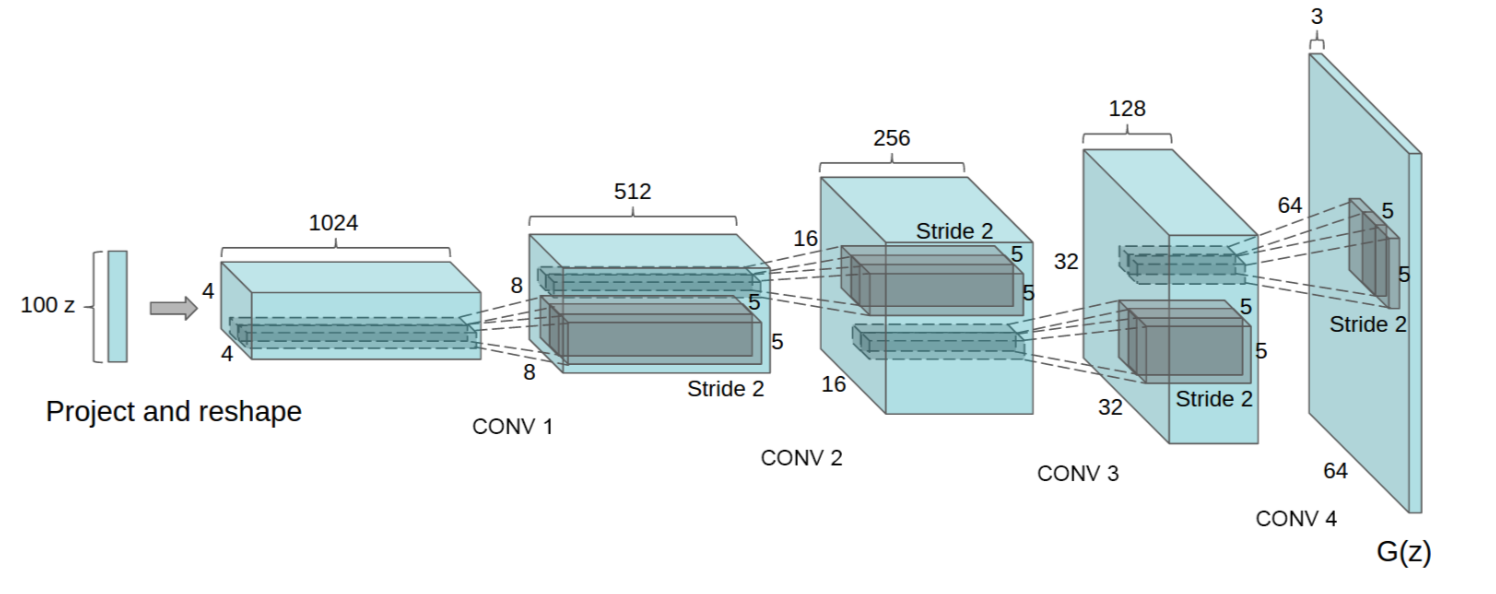

Well, following is the PyTorch implementation of DCGAN. What I need to do is rewrite the dataset loader (which only support cifar10, lsun, imagenet, folder and lfw for now) to make it compatible with customized dataset.

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw | fake')
parser.add_argument('--dataroot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

opt = parser.parse_args()
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

if opt.dataset in ['imagenet', 'folder', 'lfw']:
    # folder dataset
    dataset = dset.ImageFolder(root=opt.dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(opt.imageSize),
                                   transforms.CenterCrop(opt.imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
elif opt.dataset == 'lsun':
    dataset = dset.LSUN(root=opt.dataroot, classes=['bedroom_train'],
                        transform=transforms.Compose([
                            transforms.Resize(opt.imageSize),
                            transforms.CenterCrop(opt.imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
elif opt.dataset == 'cifar10':
    dataset = dset.CIFAR10(root=opt.dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
elif opt.dataset == 'fake':
    dataset = dset.FakeData(image_size=(3, opt.imageSize, opt.imageSize),
                            transform=transforms.ToTensor())
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = 3


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = _netD(ngpu)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCELoss()

input = torch.FloatTensor(opt.batchSize, 3, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(opt.batchSize)
real_label = 1
fake_label = 0

if opt.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if opt.cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

## CNN:
Refer [another work](http://ieeexplore.ieee.org/document/7440871/) 
which proposed an implementation of a DL based method for the problem 
of detecting blood vessels on the fundus imagery, I thought the 
cytoskeleton structure is similar to fundus bool vessels.
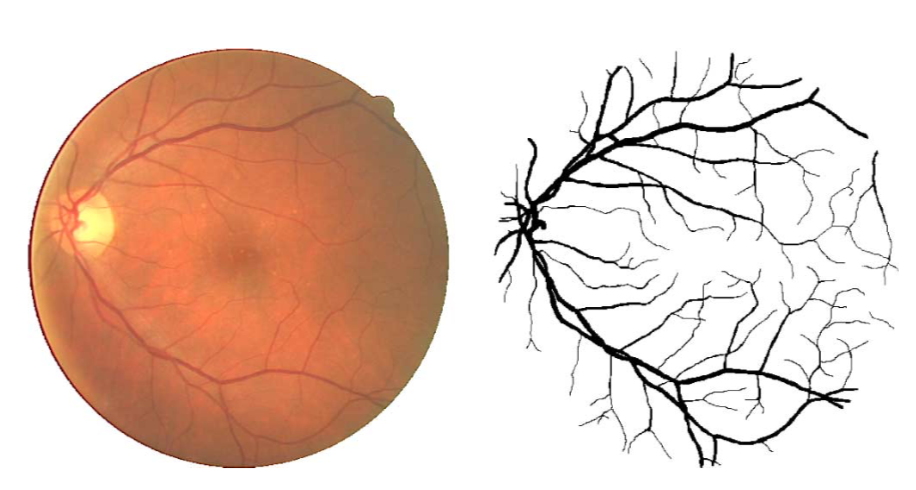, which means we can apply the module on our detection task with limited alteration hyperparameters.